<a href="https://colab.research.google.com/github/Hannah1011/llm-response-clustering/blob/main/kmeans_experiement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
파일명: ver2_response_cluster.ipynb
목표:
- 임베딩 데이터 바탕으로 클러스터링 진행
- t-sne 사용해서 클러스터링 결과 시각적으로 분석
'''

In [ ]:
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
# Load data with embeddings
datafile_path = "/content/human_feedback_embedding_large.csv"
df = pd.read_csv(datafile_path)

# Convert embeddings: string → numpy array
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
matrix.shape

(87, 3072)

In [ ]:
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", n_init= 15, max_iter=400, random_state=0)
kmeans.fit(matrix)
df["cluster"] = kmeans.labels_

In [ ]:
df.groupby("cluster").quality.mean().sort_values()

,quality
cluster,
0,-0.111111
9,0.272727
4,0.333333
7,0.333333
8,0.466667
3,0.529412
6,0.600000
1,0.714286
2,0.750000


In [ ]:
silhouette_values = silhouette_samples(matrix, kmeans.labels_)
df["silhouette_value"] = silhouette_values

# Average silhouette score for each cluster
cluster_silhouette_avg = df.groupby("cluster")["silhouette_value"].mean()
print("Cluster-wise Average Silhouette Scores:")
print(cluster_silhouette_avg)

Cluster-wise Average Silhouette Scores:
cluster
0    0.090584
1    0.454132
2    0.334315
3    0.040014
4    0.681082
5    0.444220
6    0.086702
7    0.444446
8    0.002322
9   -0.032401
Name: silhouette_value, dtype: float64


In [ ]:
# Silhouette Score
silhouette_avg = silhouette_score(matrix, kmeans.labels_)
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}")
#초기값 : 0.17

Silhouette Score for 10 clusters: 0.17052210682936178


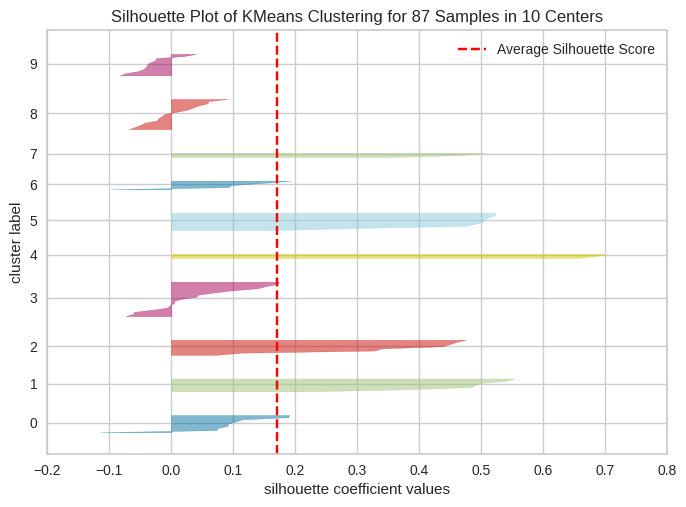

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 87 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualize silhouette scores
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(matrix)
visualizer.show()

In [ ]:
cluster_counts = df["cluster"].value_counts().sort_index()
print("📊 클러스터별 데이터 개수")
print(cluster_counts)

📊 클러스터별 데이터 개수
cluster
0     9
1     7
2     8
3    17
4     3
5     9
6     5
7     3
8    15
9    11
Name: count, dtype: int64


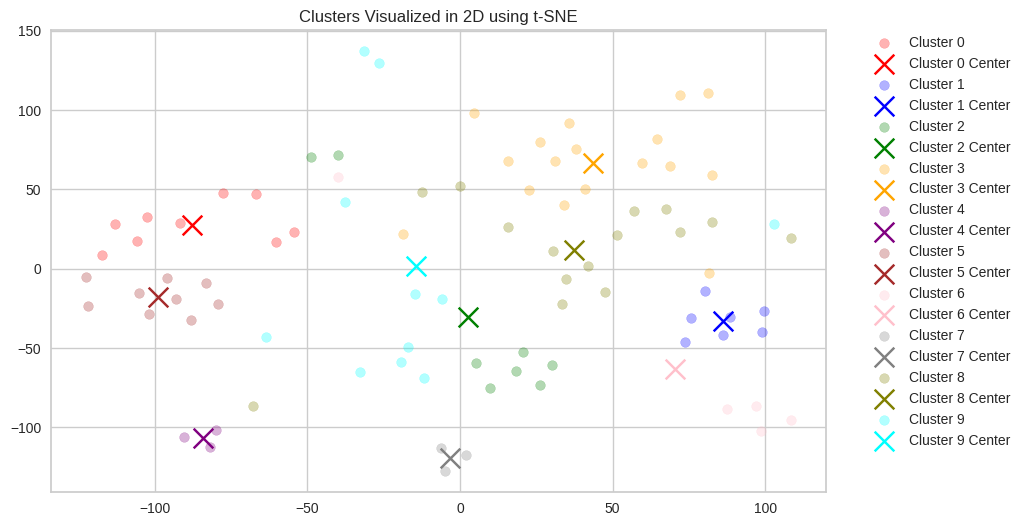

In [ ]:
# t-SNE visualization (Ref : https://cookbook.openai.com/examples/clustering)
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]
plt.figure(figsize=(10, 6))

colors = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
for category, color in enumerate(colors):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3, label=f"Cluster {category}")

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200, label=f"Cluster {category} Center")

plt.title("Clusters Visualized in 2D using t-SNE")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [ ]:
cluster_avg_quality = df.groupby("cluster").quality.mean().reset_index()
cluster_avg_quality.columns = ["cluster", "cluster_avg_quality"]
cluster_avg_quality['cluster_avg_quality'] = cluster_avg_quality['cluster_avg_quality'].round(3)
df = pd.merge(df, cluster_avg_quality, on = "cluster", how = "left")

In [ ]:
#df = df.drop(['cluster_avg_quality_x','cluster_avg_quality_y'],axis=1)

In [ ]:
df.head(2)

,coach_no,name,quality,created_at,query,answer,guide_index,combined,n_tokens,embedding,Cluster,cluster_avg_quality
0,NaN,NaN,-1,2024-12-05 13:57:09,식사 순서 바꾸기,식사 순서를 바꾸는 것은 건강한 식습관을 형성하는 데 도움이 될 수 있어요. 예를 ...,"['34', '49', '45', '42', '35', '36', '41', '32...",Query: 식사 순서 바꾸기; Answer: 식사 순서를 바꾸는 것은 건강한 식습...,396,"[0.004608238581568003, -0.019572781398892403, ...",3,0.529
1,NaN,NaN,1,2024-12-05 14:04:59,식초 희석량,식초를 희석하여 섭취할 때는 물 200mL 이상에 식초를 섞어 드시는 것이 좋습니다...,"['59', '67', '61', '62', '57', '65', '60', '58...",Query: 식초 희석량; Answer: 식초를 희석하여 섭취할 때는 물 200mL...,421,"[0.02723044343292713, -0.04090958461165428, -0...",3,0.529


In [ ]:
output_path = "./human_feedback_ver1_clustering.csv"
df.to_csv(output_path, index= False)